<a href="https://colab.research.google.com/github/rbillups/GUI-Calculator-Project/blob/main/FaceMaskCnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
drive.mount('/content/drive')

Mounted at /content/drive


Pre-Processing

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
PATH = '/content/drive/MyDrive/Face Mask Dataset/'

# train dataset
train_dir = os.path.join(PATH, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)

# validation dataset
validation_dir = os.path.join(PATH, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)
# test dataset
test_dir = os.path.join(PATH, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=False)                                                         


Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


In [ ]:
# class names
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


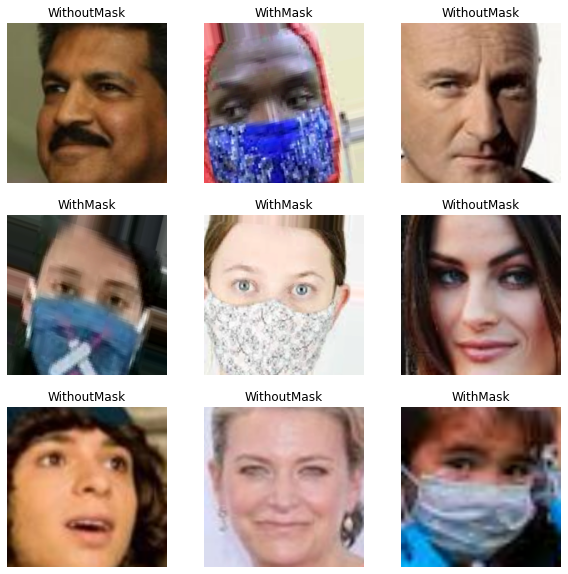

In [ ]:
# data visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# autotune buffer to avoid I/0 block
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 2

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])




In [ ]:
# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

In [ ]:
model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=5,
  callbacks =[earlystopping]
)
model.summary()

Epoch 1/5
313/313 [==============================] - 913s 3s/step - loss: 3.2850 - accuracy: 0.7781 - val_loss: 0.2988 - val_accuracy: 0.8813
Epoch 2/5
313/313 [==============================] - 783s 3s/step - loss: 0.1369 - accuracy: 0.9539 - val_loss: 0.0799 - val_accuracy: 0.9700
Epoch 3/5
313/313 [==============================] - 797s 3s/step - loss: 0.0766 - accuracy: 0.9732 - val_loss: 0.2888 - val_accuracy: 0.8875
Epoch 4/5
313/313 [==============================] - 782s 2s/step - loss: 0.0640 - accuracy: 0.9763 - val_loss: 0.1121 - val_accuracy: 0.9688
Epoch 5/5
313/313 [==============================] - 793s 3s/step - loss: 0.0593 - accuracy: 0.9794 - val_loss: 0.0797 - val_accuracy: 0.9663
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_p

In [ ]:
model.save('FaceMasK.h5')
e = model.evaluate(test_ds)

print(f'Test set accuracy: {"{0:.2f}".format(e[1]*100)}%')

31/31 [==============================] - 133s 4s/step - loss: 0.2563 - accuracy: 0.9738
Test set accuracy: 97.38%


In [ ]:
test_pred = model.predict(test_ds)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 32s 1s/step


Text(0.5, 1.0, 'Confusion Matrix - Val Set')

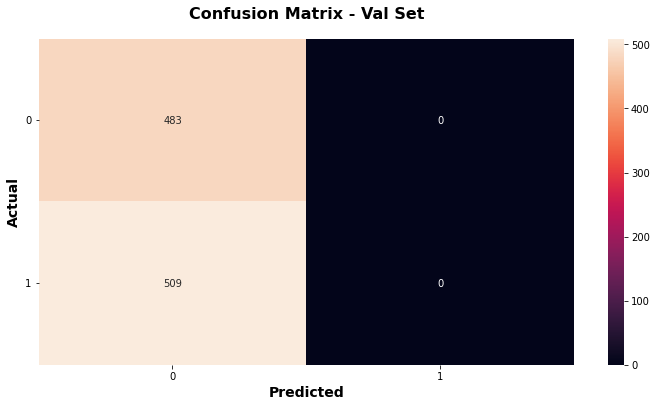

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Val Set',fontsize = 16,weight = 'bold',pad=20)

In [ ]:
import cv2
from PIL import Image
pred_img =r'/content/drive/MyDrive/medical-person-with-white-mask.jpg'
img=cv2.imread (pred_img)
img=img/255 # rescale the image
print(img.shape)
img=cv2.resize(img, (256,256)) # resize to same size used in training
print (img.shape)
img=np.expand_dims(img, axis=0)
print (img.shape)
pred=model.predict(img)
print (pred)  # will be a list of 8 elements select the element in the list with the highest probability
index=np.argmax(pred) # this will be the index of the class predicted
class_name=class_names[index] # this will be the name of the class predicted
print (class_name)


(667, 1000, 3)
(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 0s 375ms/step
[[0.49733838]]
WithMask
